In [9]:
%load_ext autoreload
%autoreload 2
%aimport -jax
%aimport -jaxlib


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import jax
import jax.numpy as jnp
import optax
from jax.random import PRNGKey

from stanza.train import Trainer
from stanza.data import PyTreeData, Data

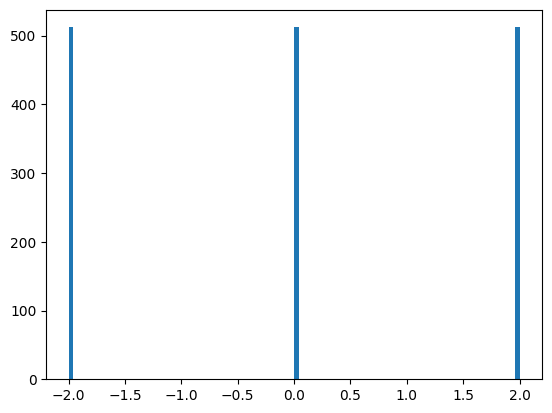

In [11]:
# create a dataset consisting of 4 deltas
data = Data.from_pytree(
    jnp.repeat(jnp.array([-2., 2.]), 512)
)
def plot_samples(samples):
    import matplotlib.pyplot as plt
    plt.hist(samples, bins=100)
    plt.show()
plot_samples(data.data)


In [12]:
from stanza.diffusion.ddpm import DDPMSchedule
schedule = DDPMSchedule.make_squaredcos_cap_v2(100, clip_sample_range=3.0)

In [13]:
from typing import Sequence
from stanza.nets.util import SinusoidalPosEmbed
import flax.linen as nn

class MLP(nn.Module):
    features: Sequence[int]
    @nn.compact
    def __call__(self, x):
        for (i, feat) in enumerate(self.features[:-1]):
            layer = nn.Dense(feat, name=f"layer_{i}")
            x = nn.gelu(layer(x))
        x = nn.Dense(self.features[-1],
          name=f"layer_{len(self.features)-1}"
        )(x)
        return x

class DiffuseMLP(nn.Module):
    features: Sequence[int]
    embed_dims: int
    embed_linear_dims: int
    @nn.compact
    def __call__(self, noised_sample, timestep):
        sample_flat, sample_uf = jax.flatten_util.ravel_pytree(noised_sample)
        time_embed = SinusoidalPosEmbed(self.embed_dims)(timestep)
        time_embed = nn.Dense(self.embed_linear_dims, name="embed")(time_embed)
        x = jnp.concatenate((sample_flat, time_embed), axis=-1)
        x = MLP(list(self.features) + [sample_flat.shape[-1]],
                name='mlp')(x)
        x = 10*jax.nn.tanh(x)
        x = sample_uf(x)
        return x

model = DiffuseMLP(features=[64, 128, 64],
                   embed_dims=32, embed_linear_dims=64)

In [14]:
init_params = model.init(PRNGKey(42), data[0], 0)
print(model.apply(init_params, 5., 0))

-1.3618879


In [15]:
from stanza.diffusion.ddpm import DDPMSchedule
from stanza.util import mse_loss
from stanza.train import batch_loss as to_batch_loss

def loss(state, params, rng, sample):
    t_rng, n_rng = jax.random.split(rng)
    timestep = jax.random.randint(t_rng, (), 0, schedule.num_steps)
    noised_sample, noise = schedule.add_noise(n_rng, sample, timestep)
    noise_pred = model.apply(params, noised_sample, timestep)
    loss = jnp.mean(jnp.square(noise - noise_pred))
    return state, loss, {"loss": loss}

batch_loss = to_batch_loss(loss)
opt = optax.adamw(optax.cosine_decay_schedule(1e-4, 20000), weight_decay=1e-6)

In [17]:
from stanza.reporting.wandb import WandbDatabase
db = WandbDatabase("dpfrommer-projects/ddpm_example").create()
from stanza.util.logging import logger
logger.info("{}", db.name)
from stanza.reporting.jax import JaxDBScope
from stanza.util.rich import ConsoleDisplay, StatisticsTable, LoopProgress

db_scope = JaxDBScope(db)
display = ConsoleDisplay()
display.add("train", StatisticsTable(), interval=100)
display.add("train", LoopProgress(), interval=100)

with display as w, db_scope as db_handle:
    trainer = Trainer(max_epochs=5000, batch_size=256, optimizer=opt)
    logger_hook = db_handle.statistic_logging_hook()
    res = trainer.train(
        loss_fn=batch_loss, dataset=data,
        rng_key=PRNGKey(42), init_params=init_params,
        train_hooks=[w.train, logger_hook], jit=True
    )

[00:23:53] INFO   - polished-disco-62                                                                ]8;id=688307;file:///tmp/ipykernel_57430/767575660.py\767575660.py]8;;\:]8;id=403132;file:///tmp/ipykernel_57430/767575660.py#4\4]8;;\

Output()

           TRACE  - <Tracing> Tracing batch loss                                                    ]8;id=412746;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=678069;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#279\279]8;;\

[00:23:54] TRACE  - <Tracing> Tracing training                                                      ]8;id=105500;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=105735;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#122\122]8;;\

           TRACE  - <Tracing> Tracing epoch step                                                    ]8;id=550884;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=909924;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#104\104]8;;\

           TRACE  - <Tracing> Tracing train step                                                     ]8;id=648892;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=90945;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#69\69]8;;\

           TRACE  - <Tracing> Done tracing training                                                 ]8;id=276065;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=50302;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#131\131]8;;\

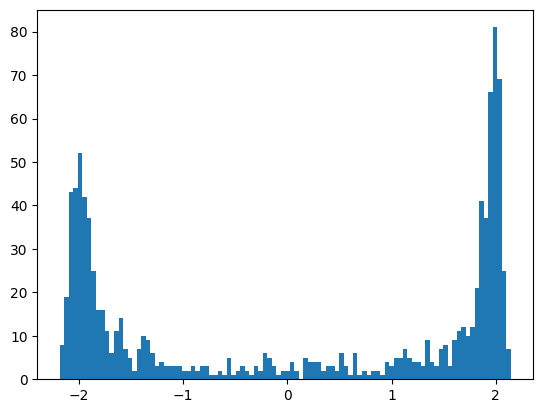

In [18]:
from stanza import Partial
diffuser = Partial(lambda _, s, t: model.apply(res.fn_params, s, t))
# def diffuser(_, state, t):
#     a_sqrt = jnp.sqrt(1 - schedule.alphas_cumprod[t])
#     return state/a_sqrt

def sample(rng_key):
    return schedule.sample(rng_key, diffuser, jnp.array(0.0), trajectory=True)
samples, trajectories = jax.vmap(sample)(jax.random.split(PRNGKey(5), 1000))
plot_samples(samples)

(100, 100) (100, 100)


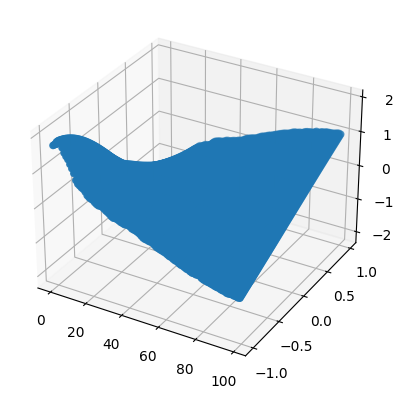

In [19]:
xv, yv = jnp.meshgrid(jnp.arange(schedule.num_steps), jnp.arange(100)/50 - 1)
print(xv.shape, yv.shape)
xv = xv.reshape(-1)
yv = yv.reshape(-1, 1)
noise_pred = jax.vmap(diffuser, in_axes=(None, 0, 0))(None, yv, xv)
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xv, yv.squeeze(), noise_pred.squeeze())

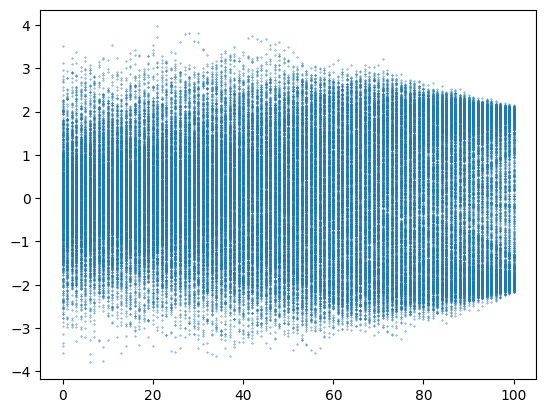

In [20]:
def plot_trajectories(trajs):
    T = trajs.shape[1]
    steps = jnp.repeat(jnp.arange(T)[None,:], trajs.shape[0], axis=0)
    x = jnp.reshape(steps, (-1,))
    y = jnp.reshape(trajs, (-1,))
    import matplotlib.pyplot as plt
    plt.clf()
    plt.scatter(x, y, s=0.1)
plot_trajectories(trajectories)
